# Import Libraries

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[pillow, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline 

Traceback (most recent call last):
  File "<string>", line 1, in <module>
ModuleNotFoundError: No module named 'monai'


In [2]:
%matplotlib inline
import copy
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import random 
import os
import seaborn as sns
import skimage
from skimage import io, transform
from sklearn.metrics import confusion_matrix
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from tqdm import tqdm, notebook, tqdm_notebook
from torchvision import datasets, models, transforms
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

from monai.apps import download_and_extract
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
    Resize,
)
from monai.utils import set_determinism
from warnings import filterwarnings
filterwarnings("ignore", category=DeprecationWarning) 

print_config()

MONAI version: 1.1.dev2241
Numpy version: 1.21.6
Pytorch version: 1.11.0
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 3aec844d8fb56a9a9be2c945ae581e59edd0c8f7
MONAI __file__: /opt/conda/lib/python3.7/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.10
Nibabel version: 4.0.2
scikit-image version: 0.19.3
Pillow version: 9.1.1
Tensorboard version: 2.10.0
gdown version: NOT INSTALLED or UNKNOWN VERSION.
TorchVision version: 0.12.0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.1
pandas version: 1.3.5
einops version: NOT INSTALLED or UNKNOWN VERSION.
transformers version: 4.20.1
mlflow version: NOT INSTALLED or UNKNOWN VERSION.
pynrrd version: NOT INSTALLED or UNKNOWN VERSION.

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(2001)

# Load Dataset
The dataset respective to already classified category is divided into three sets:
* test set
* train set
* validation set


In [4]:
EPOCHS = 50
data_dir = "../input/pneumonia-data-seperation/Pneumonia_Data/"
TEST = 'Test'
TRAIN = 'Train'
VAL ='Validation'

# Data Preprocessing and Augmentation
> Deep learning models usually require a lot of data for training. In general, the more the data, the better the performance of the model.

> Image Augmentation is the process of generating new images for training our deep learning model. These new images are generated using the existing training images and hence we don’t have to collect them manually.

In [5]:
def data_transforms(phase):
    if phase == TRAIN:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
#             transforms.CenterCrop(224),
#             transforms.RandomHorizontalFlip(0.5),
#             transforms.RandomRotation(10),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
        
    if phase == VAL:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
#             transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])
    
    if phase == TEST:
        transform = transforms.Compose([
            transforms.Resize((256, 256)),
#             transforms.CenterCrop(224),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
        ])        
        
    return transform

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [6]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms(x)) 
                  for x in [TRAIN, VAL, TEST]}

dataloaders = {TRAIN: torch.utils.data.DataLoader(image_datasets[TRAIN], batch_size = 64, shuffle=True), 
               VAL: torch.utils.data.DataLoader(image_datasets[VAL], batch_size = 32, shuffle=True), 
               TEST: torch.utils.data.DataLoader(image_datasets[TEST], batch_size = 1, shuffle=True)}

In [7]:
# 4163/40
104 * 40

4160

In [8]:
len(dataloaders[VAL])

7

In [9]:
dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, VAL]}
classes = image_datasets[TRAIN].classes
class_names = image_datasets[TRAIN].classes

# Visualize the Chest X-rays

In [10]:
# def imshow(inp, title=None):
#     inp = inp.numpy().transpose((1, 2, 0))
#     mean = np.array([0.485, 0.456, 0.406])
#     std = np.array([0.229, 0.224, 0.225])
#     inp = std * inp + mean
#     inp = np.clip(inp, 0, 1)
#     plt.imshow(inp)
#     if title is not None:
#         plt.title(title)
#     plt.pause(0.001)  


# inputs, classes = next(iter(dataloaders[TRAIN]))
# out = torchvision.utils.make_grid(inputs)
# imshow(out, title=[class_names[x] for x in classes])

In [11]:
inputs, classes = next(iter(dataloaders[TRAIN]))

# Define Function for Training

In [12]:
def train_model(model, criterion, optimizer, scheduler, num_epochs):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    for epoch in tqdm_notebook(range(num_epochs), desc = 'Epochs'):
        print('\n')
        print("Epoch: {}/{}".format(epoch+1, num_epochs))
        print('-'*10)
        
        for phase in [TRAIN, VAL]:
            if phase == TRAIN:
                scheduler.step()
                model.train()
            else:
                model.eval()
            running_loss = 0.0
            running_corrects = 0
            valid = lambda x: 'Validation' if x == 'Test' else x
            for data in tqdm_notebook(dataloaders[phase], desc=f'{valid(phase)}', leave=False):
                inputs, labels = data
                inputs = inputs.to(device)
                labels = labels.to(device)
                optimizer.zero_grad()
                with torch.set_grad_enabled(phase==TRAIN):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    if phase == 'Train':
                        loss.backward()
                        optimizer.step()
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                valid(phase), epoch_loss, epoch_acc))
            writer.add_scalar(f'Loss/{valid(phase)}', epoch_loss, epoch)
            writer.add_scalar(f'Accuracy/{valid(phase)}', epoch_acc, epoch)

            if phase == 'Validation' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                
            torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': epoch_loss,
            }, f'./{epoch + 1}.pt')

    print('Best val Acc: {:4f}'.format(best_acc))
    model.load_state_dict(best_model_wts)
    return model

# Load the pretrained model from Pytorch

In [13]:
model_pre = DenseNet121(spatial_dims=2, in_channels=3,
                    out_channels=2, pretrained=True).to(device)

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

# Define the Hyperparameters

In [14]:
model_pre = model_pre.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_pre.parameters(), 1e-5)
# optimizer = optim.Adam(model_pre.parameters(), lr=0.001, momentum=0.9, weight_decay=0.01)
# Decay LR by a factor of 0.1 every 10 epochs
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

# Train Phase

In [15]:
# 141*40

In [16]:
model_pre = train_model(model_pre, criterion, optimizer, exp_lr_scheduler, num_epochs=EPOCHS)

Epochs:   0%|          | 0/50 [00:00<?, ?it/s]



Epoch: 1/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.3376 Acc: 0.8974


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.2062 Acc: 0.9300


Epoch: 2/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.1454 Acc: 0.9627


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1437 Acc: 0.9600


Epoch: 3/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0967 Acc: 0.9739


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1283 Acc: 0.9550


Epoch: 4/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0675 Acc: 0.9807


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1048 Acc: 0.9550


Epoch: 5/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0492 Acc: 0.9886


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0910 Acc: 0.9600


Epoch: 6/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0328 Acc: 0.9934


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0966 Acc: 0.9600


Epoch: 7/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0250 Acc: 0.9954


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0986 Acc: 0.9550


Epoch: 8/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0222 Acc: 0.9963


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0920 Acc: 0.9600


Epoch: 9/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0139 Acc: 0.9993


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1006 Acc: 0.9450


Epoch: 10/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0115 Acc: 0.9991


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0958 Acc: 0.9600


Epoch: 11/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0115 Acc: 0.9991


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0935 Acc: 0.9500


Epoch: 12/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0107 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0974 Acc: 0.9450


Epoch: 13/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0102 Acc: 0.9989


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0931 Acc: 0.9550


Epoch: 14/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0098 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1101 Acc: 0.9500


Epoch: 15/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0090 Acc: 0.9995


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1094 Acc: 0.9450


Epoch: 16/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0099 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0943 Acc: 0.9650


Epoch: 17/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0105 Acc: 0.9991


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0919 Acc: 0.9500


Epoch: 18/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0114 Acc: 0.9986


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0913 Acc: 0.9550


Epoch: 19/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0096 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0942 Acc: 0.9450


Epoch: 20/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0087 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0928 Acc: 0.9700


Epoch: 21/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0091 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0964 Acc: 0.9650


Epoch: 22/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0087 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0997 Acc: 0.9650


Epoch: 23/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0089 Acc: 0.9995


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0906 Acc: 0.9500


Epoch: 24/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0093 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0897 Acc: 0.9550


Epoch: 25/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0095 Acc: 0.9993


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1012 Acc: 0.9650


Epoch: 26/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0097 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0874 Acc: 0.9550


Epoch: 27/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0096 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0890 Acc: 0.9500


Epoch: 28/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0096 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0930 Acc: 0.9650


Epoch: 29/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0095 Acc: 0.9993


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0936 Acc: 0.9600


Epoch: 30/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0090 Acc: 0.9995


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0970 Acc: 0.9450


Epoch: 31/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0091 Acc: 0.9995


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0928 Acc: 0.9500


Epoch: 32/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0111 Acc: 0.9986


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0932 Acc: 0.9500


Epoch: 33/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0092 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1027 Acc: 0.9450


Epoch: 34/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0078 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0880 Acc: 0.9500


Epoch: 35/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0096 Acc: 0.9993


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0919 Acc: 0.9500


Epoch: 36/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0093 Acc: 0.9995


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0943 Acc: 0.9600


Epoch: 37/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0083 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0926 Acc: 0.9550


Epoch: 38/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0079 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0886 Acc: 0.9550


Epoch: 39/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0078 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0917 Acc: 0.9500


Epoch: 40/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0101 Acc: 0.9991


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0874 Acc: 0.9500


Epoch: 41/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0093 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0862 Acc: 0.9550


Epoch: 42/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0082 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0893 Acc: 0.9700


Epoch: 43/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0093 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.1016 Acc: 0.9450


Epoch: 44/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0097 Acc: 0.9993


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0998 Acc: 0.9450


Epoch: 45/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0094 Acc: 0.9995


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0869 Acc: 0.9550


Epoch: 46/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0085 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0937 Acc: 0.9500


Epoch: 47/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0091 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0910 Acc: 0.9500


Epoch: 48/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0112 Acc: 0.9984


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0933 Acc: 0.9500


Epoch: 49/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0086 Acc: 0.9996


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0865 Acc: 0.9500


Epoch: 50/50
----------


Train:   0%|          | 0/89 [00:00<?, ?it/s]

Train Loss: 0.0089 Acc: 0.9998


Validation:   0%|          | 0/7 [00:00<?, ?it/s]

Validation Loss: 0.0939 Acc: 0.9500
Best val Acc: 0.970000


In [17]:
# torch.cuda.empty_cache()

# Define Function for Testing

In [18]:
def test_model():
    running_correct = 0.0
    running_total = 0.0
    true_labels = []
    pred_labels = []
    with torch.no_grad():
        for data in dataloaders[TEST]:
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)
            true_labels.append(labels.item())
            outputs = model_pre(inputs)
            _, preds = torch.max(outputs.data, 1)
            pred_labels.append(preds.item())
            running_total += labels.size(0)
            running_correct += (preds == labels).sum().item()
        acc = running_correct/running_total
    return (true_labels, pred_labels, running_correct, running_total, acc)

# Testing Phase

In [19]:
true_labels, pred_labels, running_correct, running_total, acc = test_model()

# Results

In [20]:
print("Total Correct: {}, Total Test Images: {}".format(running_correct, running_total))
print("Test Accuracy: ", acc)

Total Correct: 19.0, Total Test Images: 20.0
Test Accuracy:  0.95


**Confusion Matrix, Presision and Recall**

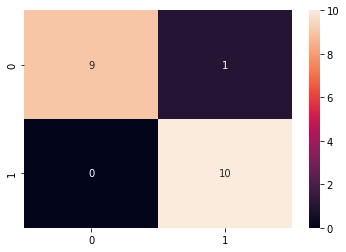

In [21]:
cm = confusion_matrix(true_labels, pred_labels)
tn, fp, fn, tp = cm.ravel()
ax = sns.heatmap(cm, annot=True, fmt="d")